Draft to measure emmsion lines. Make model line, convolve model by appropriate lsf, fit to spectrum.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [15]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [16]:
hdul = fits.open('{}hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits'.format(path))

In [17]:
data = hdul[1].data
inst_list = hdul[2].data
inst_list

FITS_rec([( 65536, 'MOD', 'LYA', 'YOUNG', 'hlsp_muscles_mod_lya_gj15a_young_v1_component-spec.fits'),
          (    16, 'HST', 'STS', 'E140M', 'hlsp_muscles_hst_sts_gj15a_e140m_v1_component-spec.fits'),
          (524288, 'HST', 'STS', 'G230LB', 'hlsp_muscles_hst_sts_gj15a_g230lb_v1_component-spec.fits'),
          (131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj15a_na_v1_component-spec.fits'),
          (   256, 'HST', 'STS', 'G430L', 'hlsp_muscles_hst_sts_gj15a_g430l_v1_component-spec.fits'),
          (131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj15a_na_v1_component-spec.fits'),
          (  8192, 'CXO', 'ACS', 'NA', 'hlsp_muscles_cxo_acs_gj15a_na_v1_component-spec.fits'),
          ( 32768, 'MOD', 'APC', 'NA', 'hlsp_muscles_mod_apc_gj15a_na_v1_component-spec.fits'),
          ( 16384, 'MOD', 'EUV', 'YOUNG', 'hlsp_muscles_mod_euv_gj15a_young_v1_component-spec.fits')],
         dtype=(numpy.record, [('BITVALUE', '>i8'), ('TELESCOPE', 'S3'), ('INSTRUMENT', 'S3'), ('GRATIN

In [18]:
mask = (data['WAVELENGTH'] > 1160) & (data['WAVELENGTH'] < 2000) & (data['INSTRUMENT'] != 65536)

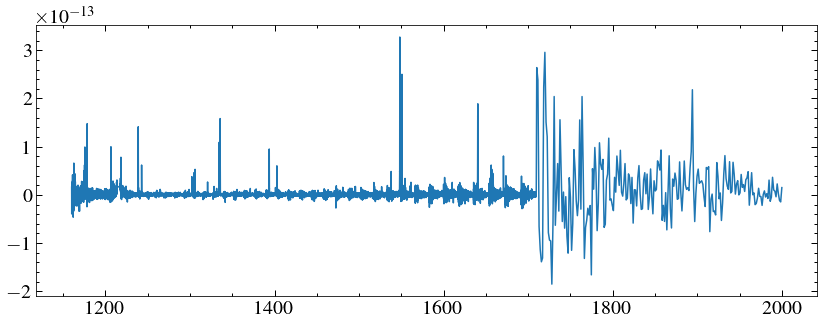

In [19]:
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])

In [27]:
line_list = Table.read('all_linelist.csv')

(1160.0, 1700.0)

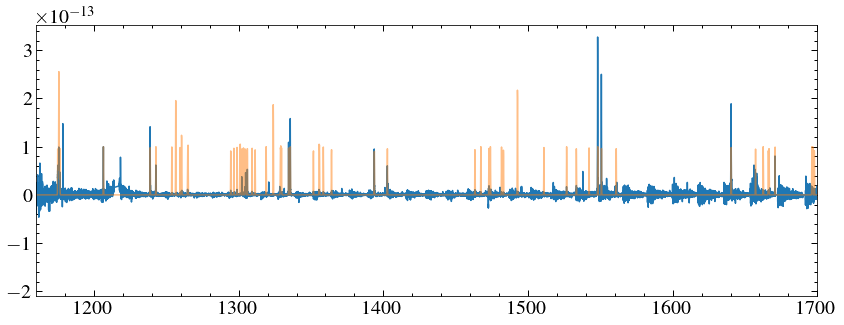

In [21]:
mod1 = models.Const1D(0)
for i in range(len(line_list)):
    amp = 1e-13
#     if line_list['Likelihood to measure'][i] == 'Low':
#         amp = amp/3
#     if line_list['Likelihood to measure'][i] == 'Medium':
#         amp = amp/2
    if line_list['Likelihood to measure'][i] in ['High', 'Medium']:
#     mod1 = mod1+ functional_models.Voigt1D(x_0=line_list['Wavelength'][i], amplitude_L=amp, fwhm_G=0.05, fwhm_L=0.05)
        mod1 = mod1 + models.Gaussian1D(amplitude=amp, mean = line_list['Wavelength'][i], stddev=0.1)


mw = np.arange(900, 1700, 0.1)
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])
plt.plot(mw, mod1(mw), alpha=0.5)
plt.xlim(1160, 1700)


-5.630908556751834 km / s 0.0 km / s


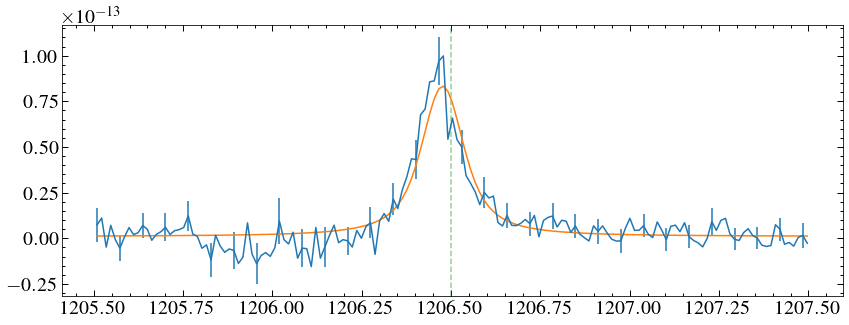

-7.65283640166608 km / s 0.0 km / s
-11.369558835408277 km / s 0.0 km / s


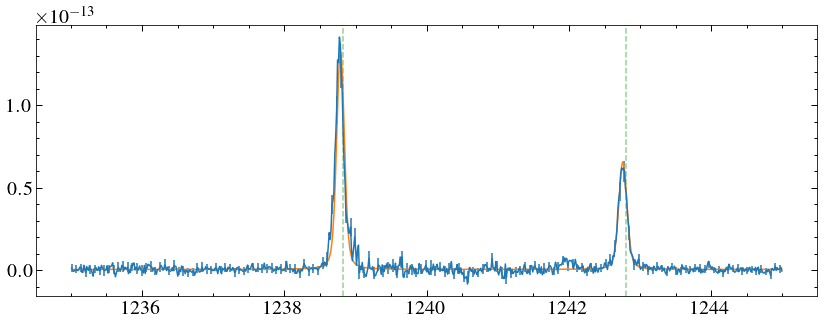

-14.07407581840951 km / s 0.0 km / s
-7.11077372957526 km / s 0.0 km / s


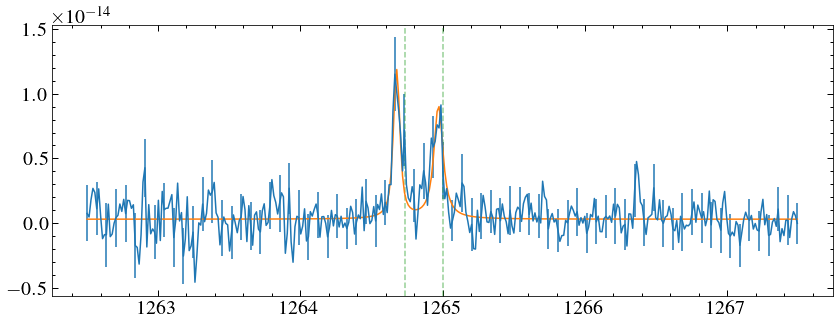

-10.575997387564556 km / s 1.9687278474123104e-08 km / s
-4.154449303053628 km / s 5.7747131521068695e-09 km / s


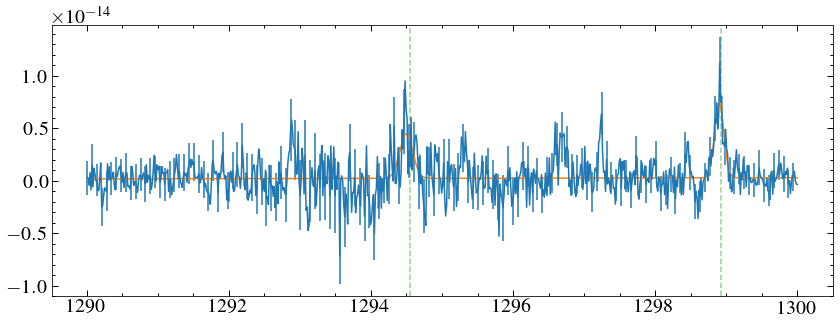

-30.741721074629375 km / s 0.0 km / s


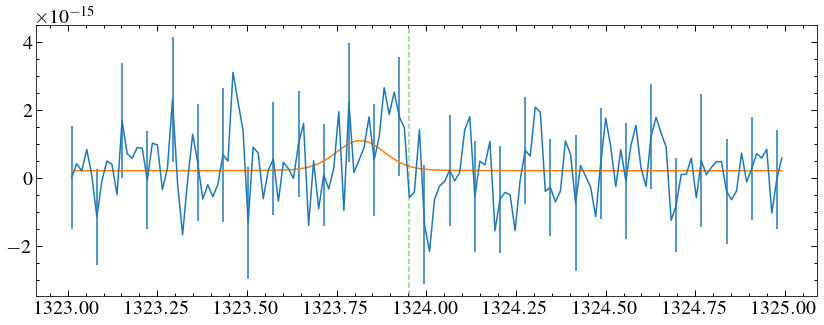

-1.1231852729168255 km / s 0.0 km / s
-9.703064250097787 km / s 0.0 km / s


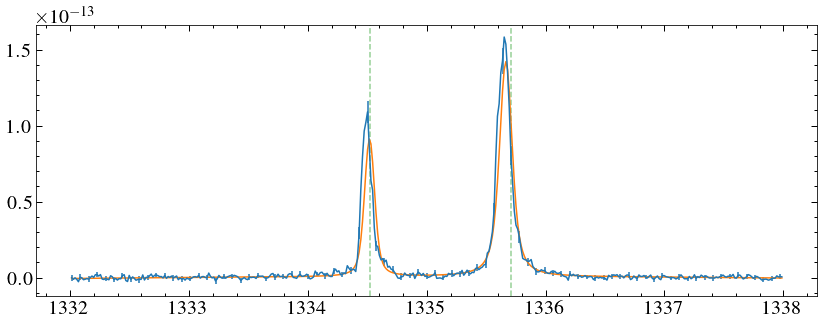

-4.4797671047380545 km / s 0.0 km / s
-2.4388578228550104 km / s 0.0 km / s


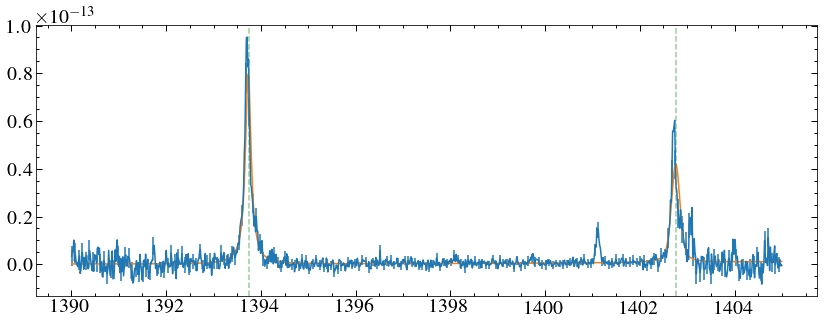

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


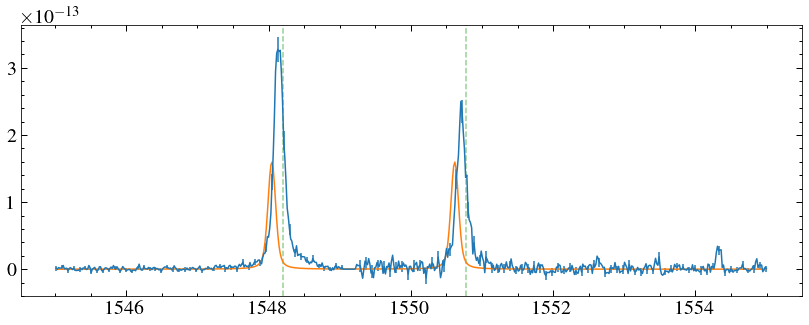

-13.588748682408392 km / s 4.992539714976374e-11 km / s


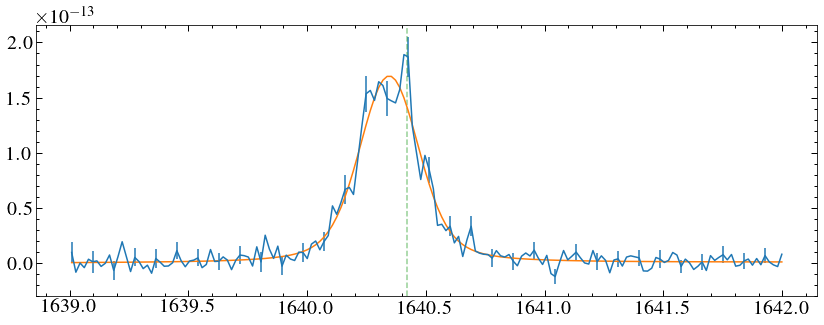

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


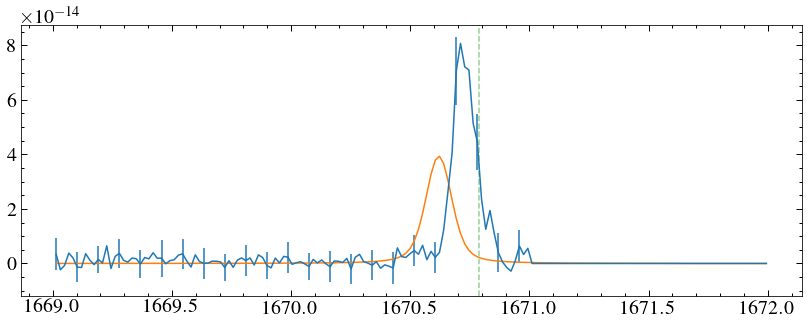

232.59148292242182 km / s 2.5467882650787033e-05 km / s
147.58711602492258 km / s 1.7871755161991132e-05 km / s


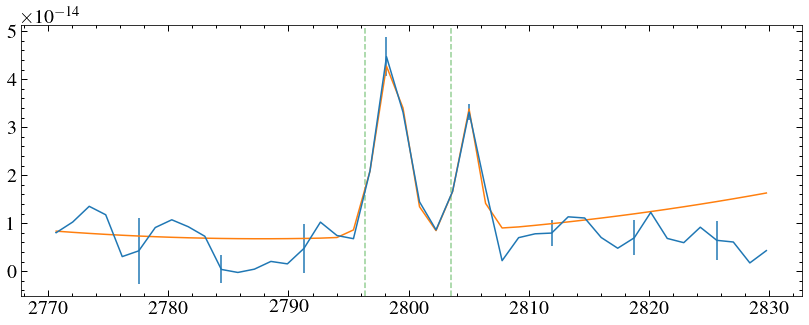

In [38]:
#50 AA chunks?
fitter = fitting.LevMarLSQFitter()
start = 1150
step = 60
w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
# lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']
lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


chunks = [[1205.5, 1207.5], [1235, 1245], [1262.5, 1267.5], [1290, 1300], [1323, 1325], [1332, 1338], [1350, 1352.5], [1390, 1405], 
          [1520, 1540], 
          [1545, 1555], [1639, 1642], [1669, 1672], [2770, 2830]]


dv_guess = -30*u.km/u.s

smooth =7 

dvs = []
dv_es = []

for chunk in chunks:
    start, end = chunk[0], chunk[1]
    mask = (w >= start) & (w <= end)

    lmask = (lines >= start) & (lines <= end)
    if len(lines[lmask]) > 0:
    #         plt.plot(w[mask], f[mask])
        fi, ei = f[mask], e[mask]

    #         mod = models.Const1D(0)
        mod = models.Polynomial1D(2)
        std_guess = 0.5
        if np.median(inst[mask]) in [1, 2, 16]:
                std_guess = 0.1
        if np.median(inst[mask]) in [1, 2]:
                fi = convolve(fi,Box1DKernel(smooth))
                ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
        plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
    #         print(std_guess)
        for line in lines[lmask]:
            line_guess = dv_guess.to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#             mod = mod+  models.Gaussian1D(amplitude=np.max(fi), mean = line_guess, stddev=std_guess)
            mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
            plt.axvline(line, ls='--', c='C2', alpha =0.5)
    #             plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
        gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=10000)
#         print(gg_fit)
        if type(fitter.fit_info['param_cov']) == np.ndarray:
        #     print('hooray!')
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
            mean_es = fit_e[4:][::4]
        
    #         print(gg_fit)
            for i in range(len(lines[lmask])):
                mean = gg_fit[i+1].x_0
#                 mean = gg_fit[i+1].mean
                mean_e = mean_es[i]
#                 line_e = 
        #             obs_line = gg_fit[i+1].mean*u.AA
        
                dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
                print(dv, dve)
                dvs.append(dv)
                dv_es.append(dve)
        
        
        
        plt.plot(w[mask], gg_fit(w[mask]))
        plt.show()
#     start += step
    

What about just doublets to get the rv?

In [23]:
dvs = np.array([dv.value for dv in dvs])

-5.418186059872826 -5.472853301637265 8.617340956019655


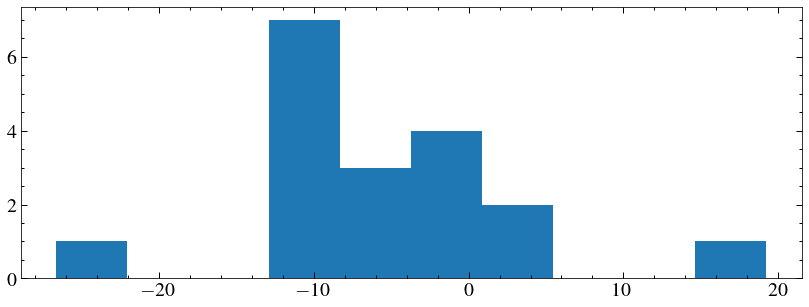

In [24]:
plt.hist(dvs)
print(np.mean(dvs), np.median(dvs), np.std(dvs))

In [25]:
np.mean([1298.892,
1298.944])

1298.9180000000001

In [26]:
dvs

array([-10.65857253,  -9.03901589,   0.22737397,   1.18007005,
         1.18007005,  -2.88812929,  -9.52329195,  -4.5796613 ,
        -8.38031887,  -9.78807758,  19.23742802, -11.83567545,
        -3.03570012, -26.65298823,  -2.93730131,  -9.08785206,
        -5.52603863,  -5.41966798])

In [45]:
specs = glob.glob('{}*var*'.format(path))
specs

['/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj649_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj1132_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj163_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj676a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj699_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj729_broadb

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj649_broadband_v1_var-res-sed.fits
16.12135570280054 km / s 0.6520206964953372 km / s
-3.8221894047294938 km / s 0.3236270936665764 km / s
3.2229003474338715 km / s 0.5419303424600781 km / s
1.5478405987272201 km / s 1.2548129525347234 km / s
5.8837997112555565 km / s 1.3334755201709325 km / s
0.57671104507146 km / s 2.405872564648883 km / s
8.144671280324992 km / s 2.2963506169879473 km / s
-20.32181754287107 km / s 2.396674850447086 km / s
0.8989155591031172 km / s 0.3767326725986368 km / s
-5.939139533006993 km / s 0.3254855449512317 km / s
120.09522513902985 km / s 18.75623358026666 km / s
215.02399254803757 km / s 117.87393361615352 km / s
105.74411085613863 km / s 16.52681701859528 km / s
99.176149453735 km / s 33.52609344504394 km / s
68.37949002875511 km / s 9.788204229535044 km / s
124.81072061176708 km / s 75.2451799723594 km / s
174.38302382779418 km / s 11.26152947957111 km / s
161.2587

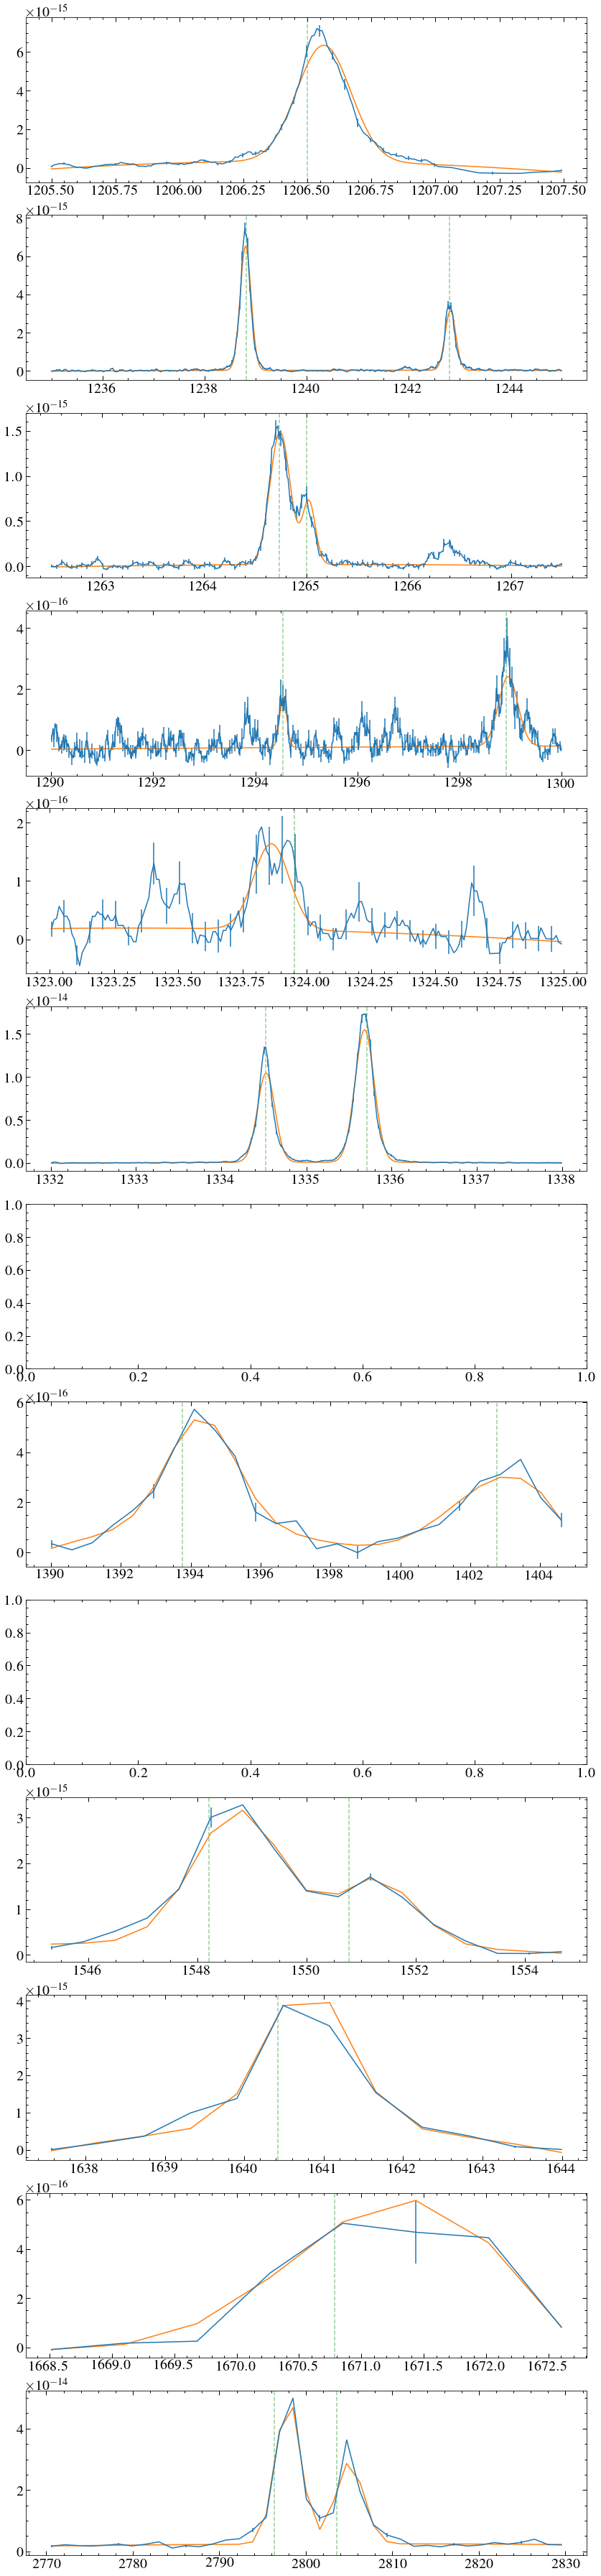

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj1132_broadband_v1_var-res-sed.fits
36.96499405260608 km / s 2.771920262580206 km / s
33.54269599794087 km / s 1.4207601810209454 km / s
44.353647643828566 km / s 2.805657055394782 km / s
28.904228485144532 km / s 29.907340350278396 km / s
12.757182922850253 km / s 209.43268053854678 km / s
-28.025673722362495 km / s 5.597473613965315 km / s
32.14658974650483 km / s 4.728504051995227 km / s
45.72046659687138 km / s 1.0521209931199387 km / s
39.404409077826934 km / s 4.704718565835702 km / s
50.33573369969854 km / s 1.1293545413675474 km / s
38.5906521927546 km / s 1.3422259788663204 km / s
36.263311335551 km / s 1.754039165730525 km / s
40.9082308566696 km / s 4.709794047144353 km / s
14.287854333395746 km / s 3.170284671262918 km / s
157.39599752692354 km / s 21.289490247960202 km / s
150.1746319905599 km / s 35.526259666331256 km / s


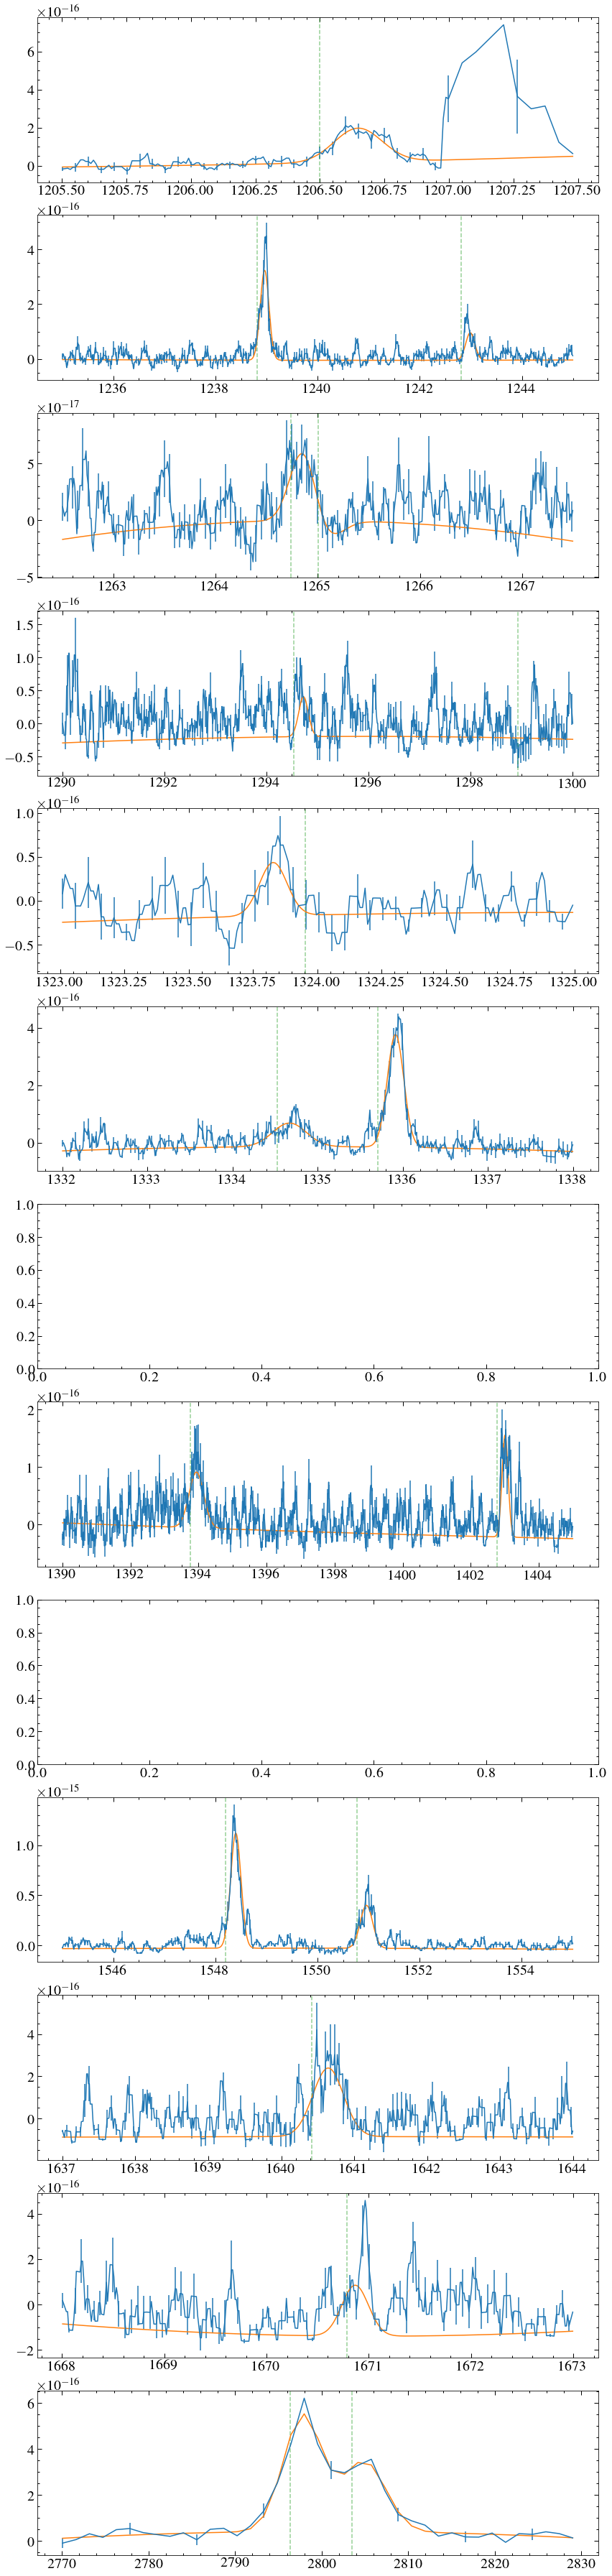

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits
-4.6974635597935555 km / s 1.4198752242126913 km / s
-7.464921387635817 km / s 0.5530661052271673 km / s
-8.375726986537371 km / s 0.6838505869009937 km / s
-5.856818197753476 km / s 9.416048279969749 km / s
-7.7114619028313545 km / s 3.8160049270657574 km / s
-9.905434073583093 km / s 6.809787621096207 km / s
-4.024892631524821 km / s 2.628088047412798 km / s
-32.95262750794959 km / s 24.946578867819213 km / s
0.5429339157028708 km / s 0.8604057326325023 km / s
-8.105310555105733 km / s 0.5972600435026028 km / s
-4.143606144682741 km / s 0.854106037477099 km / s
-1.4209207027011537 km / s 1.7126703469560915 km / s
-12.834466942123575 km / s 0.8219115575148948 km / s


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt


21.673235973644513 km / s nan km / s
148.29067514170302 km / s 39.25974289575244 km / s


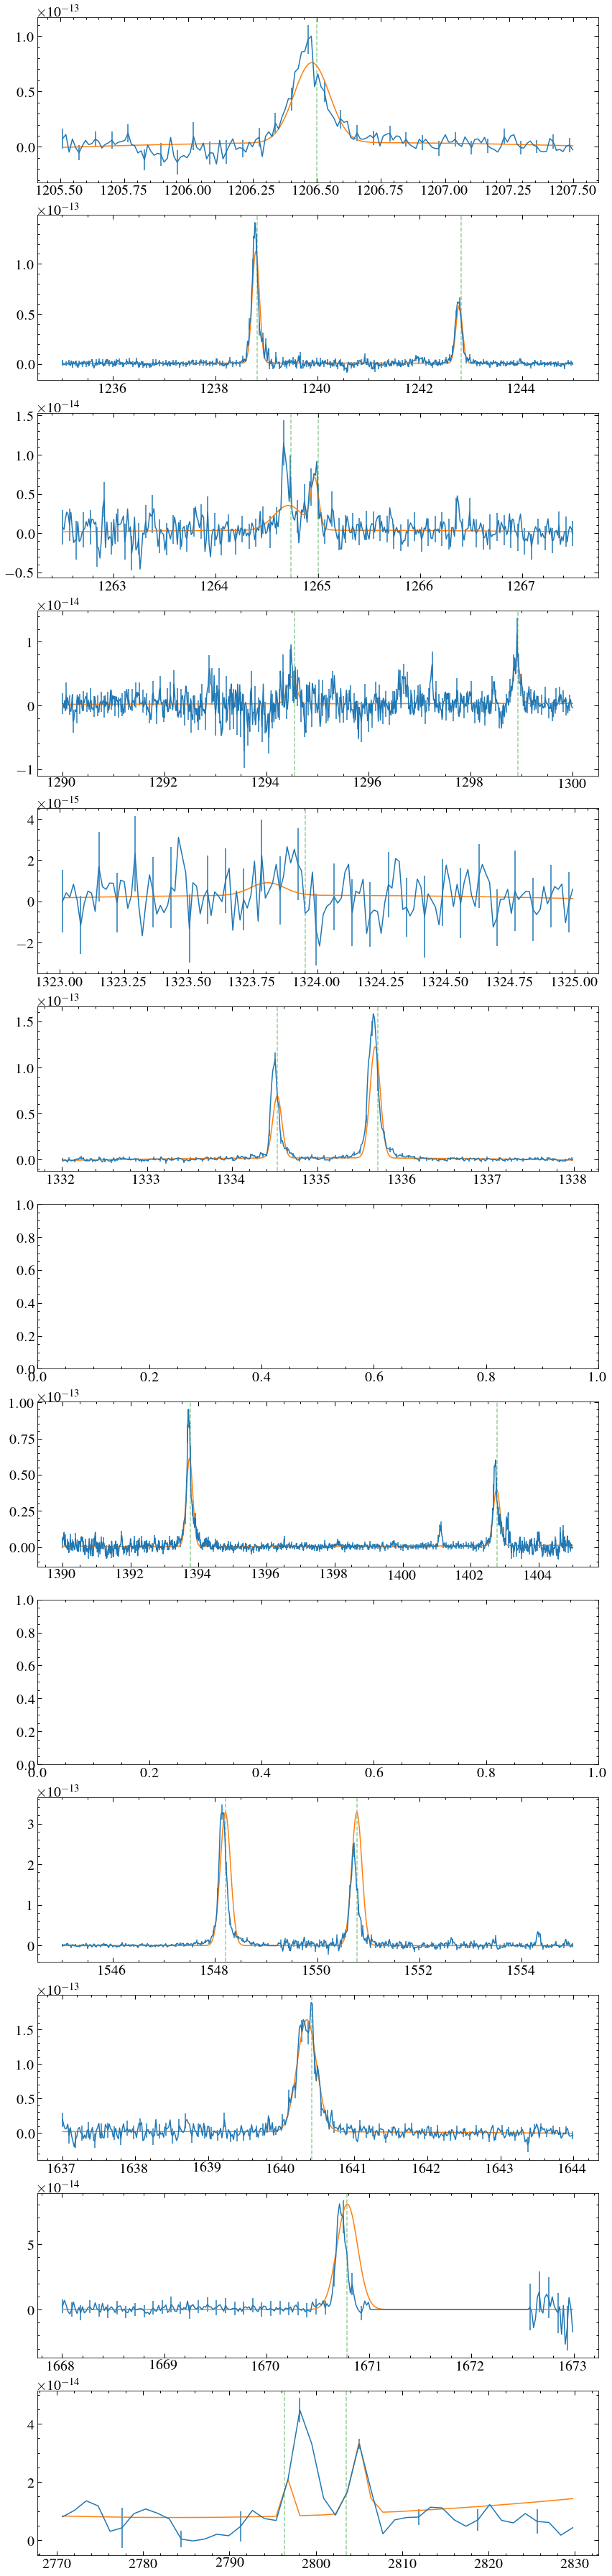

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj163_broadband_v1_var-res-sed.fits
40.97143707137801 km / s 3.6707593455435834 km / s
44.1947560472349 km / s 0.9864930459685084 km / s
45.26167966707005 km / s 2.264457955567469 km / s
89.44219697607483 km / s 11.339358885015649 km / s
67.7514702882087 km / s 5.918480336957401 km / s
23.40285614319176 km / s 11.771407846328149 km / s
59.982918887000494 km / s 0.6817964723106869 km / s
55.484276623679214 km / s 0.5877518951034908 km / s
59.12070706355523 km / s 1.555332146536756 km / s
51.28229282142772 km / s 2.9865803100530393 km / s
4.33478493974912 km / s 3.017350920821989 km / s
161.04708389167158 km / s 8.643734872308016 km / s
138.0697398001737 km / s 14.360279656652743 km / s


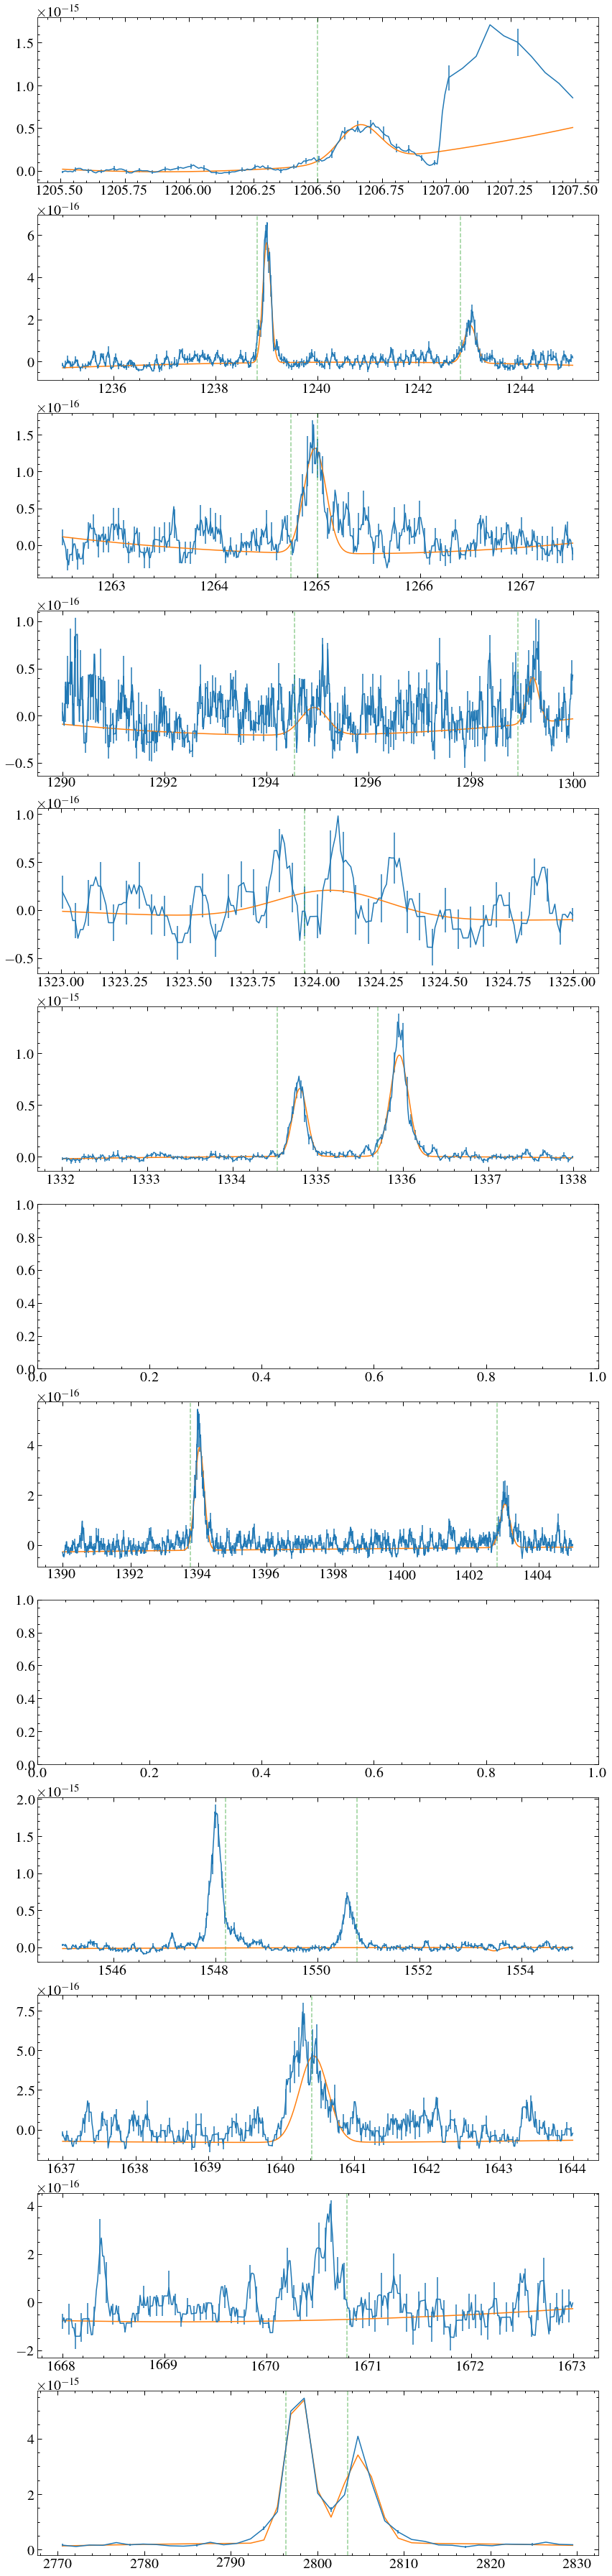

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits
5.883435385771479 km / s 0.7898826047275804 km / s
-6.031460427319804 km / s 0.8194674332474254 km / s
-2.5256588668272886 km / s 0.9602377561911987 km / s
-1.1315352996929207 km / s 2.4462800248809202 km / s
9.081845110343263 km / s 1.964005317214054 km / s
-0.458270826651029 km / s 1.0416825078206702 km / s
-0.4423438571725171 km / s 1.0248853490063303 km / s
-20.453350180796413 km / s 1.290551940193149 km / s
-4.050103570263992 km / s 1.0139684611123385 km / s
-10.312350531671296 km / s 0.8688197354246467 km / s
-43.04637707507786 km / s 15.650425929624966 km / s
-98.64160982327444 km / s 32.28820168858279 km / s
-48.2770096476971 km / s 10.439333767080416 km / s
-46.77226358861317 km / s 14.485285290872348 km / s
-25.772472426542354 km / s 7.155664599817598 km / s
-9.288907213796868 km / s 21.493550202774216 km / s
50.88713658395971 km / s 10.71280083661868 km

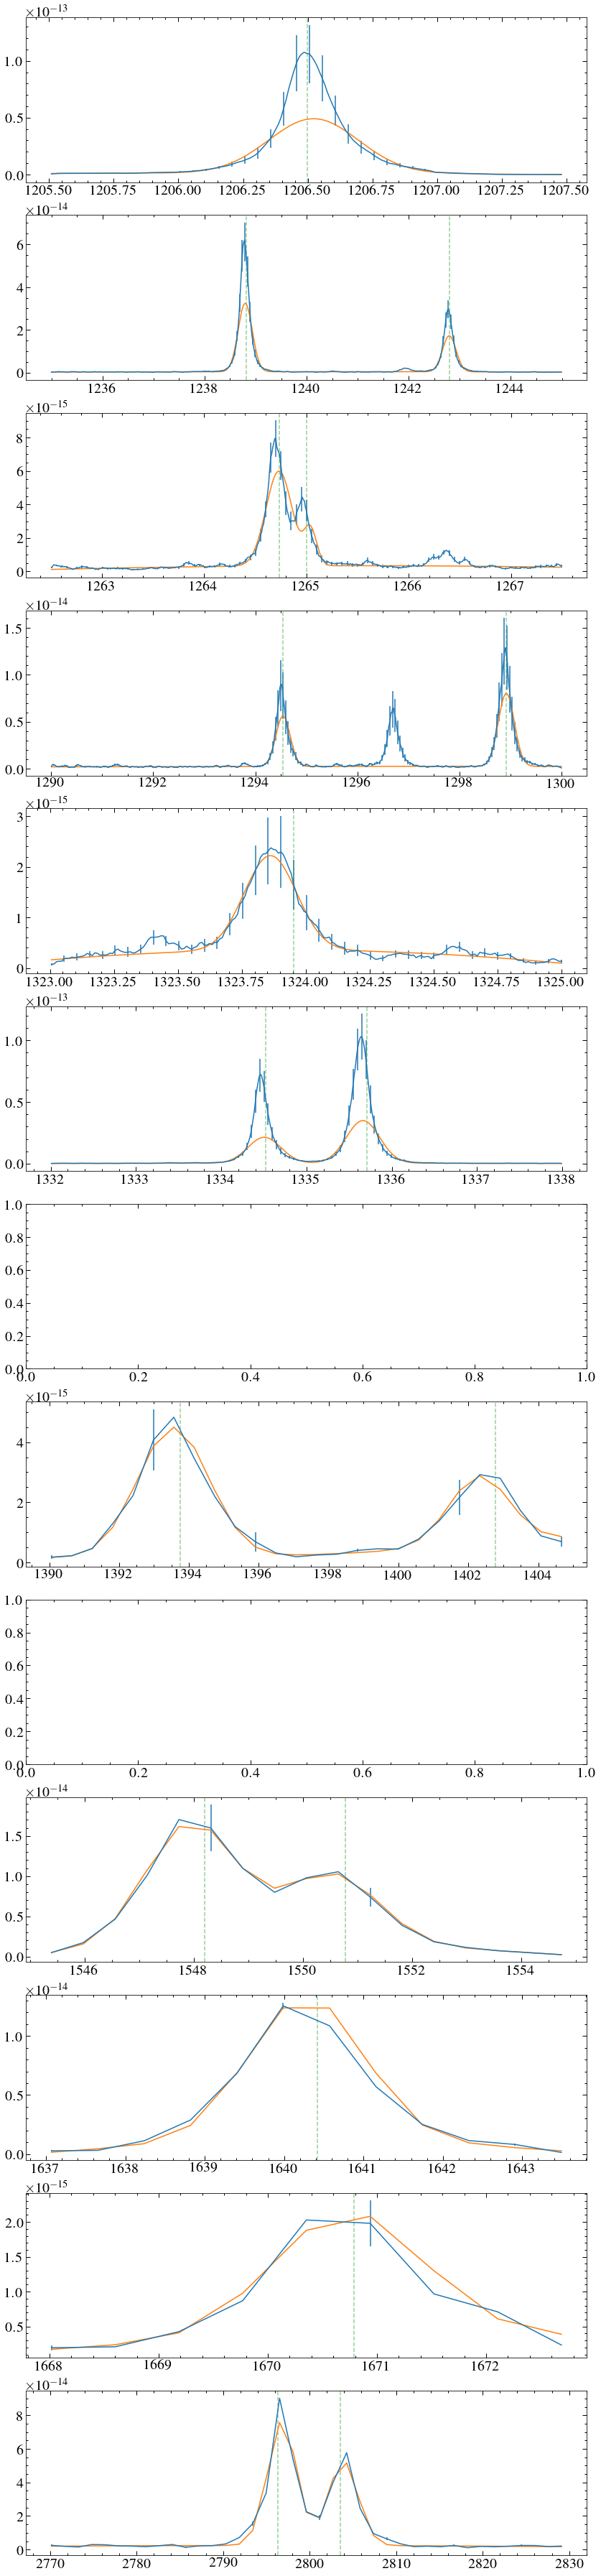

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj676a_broadband_v1_var-res-sed.fits
-39.44655589186051 km / s 0.6206047118291735 km / s
-27.62373621201739 km / s 1.479587157216379 km / s
-2.9054974381086285 km / s 38.37599502398456 km / s
-30.910094373283442 km / s 11.538025894800386 km / s
-72.31423582765561 km / s 67.46664032215872 km / s
-6.734670039525464 km / s 14.096092397133877 km / s
2.0150710987337472 km / s 23.332875353724244 km / s
-67.54053091387662 km / s 17.957543874147447 km / s
-30.182889621213533 km / s 6.295445465439325 km / s
380.27342481807057 km / s 12.791159380969532 km / s
23.98883717323235 km / s 1705218.4532800522 km / s


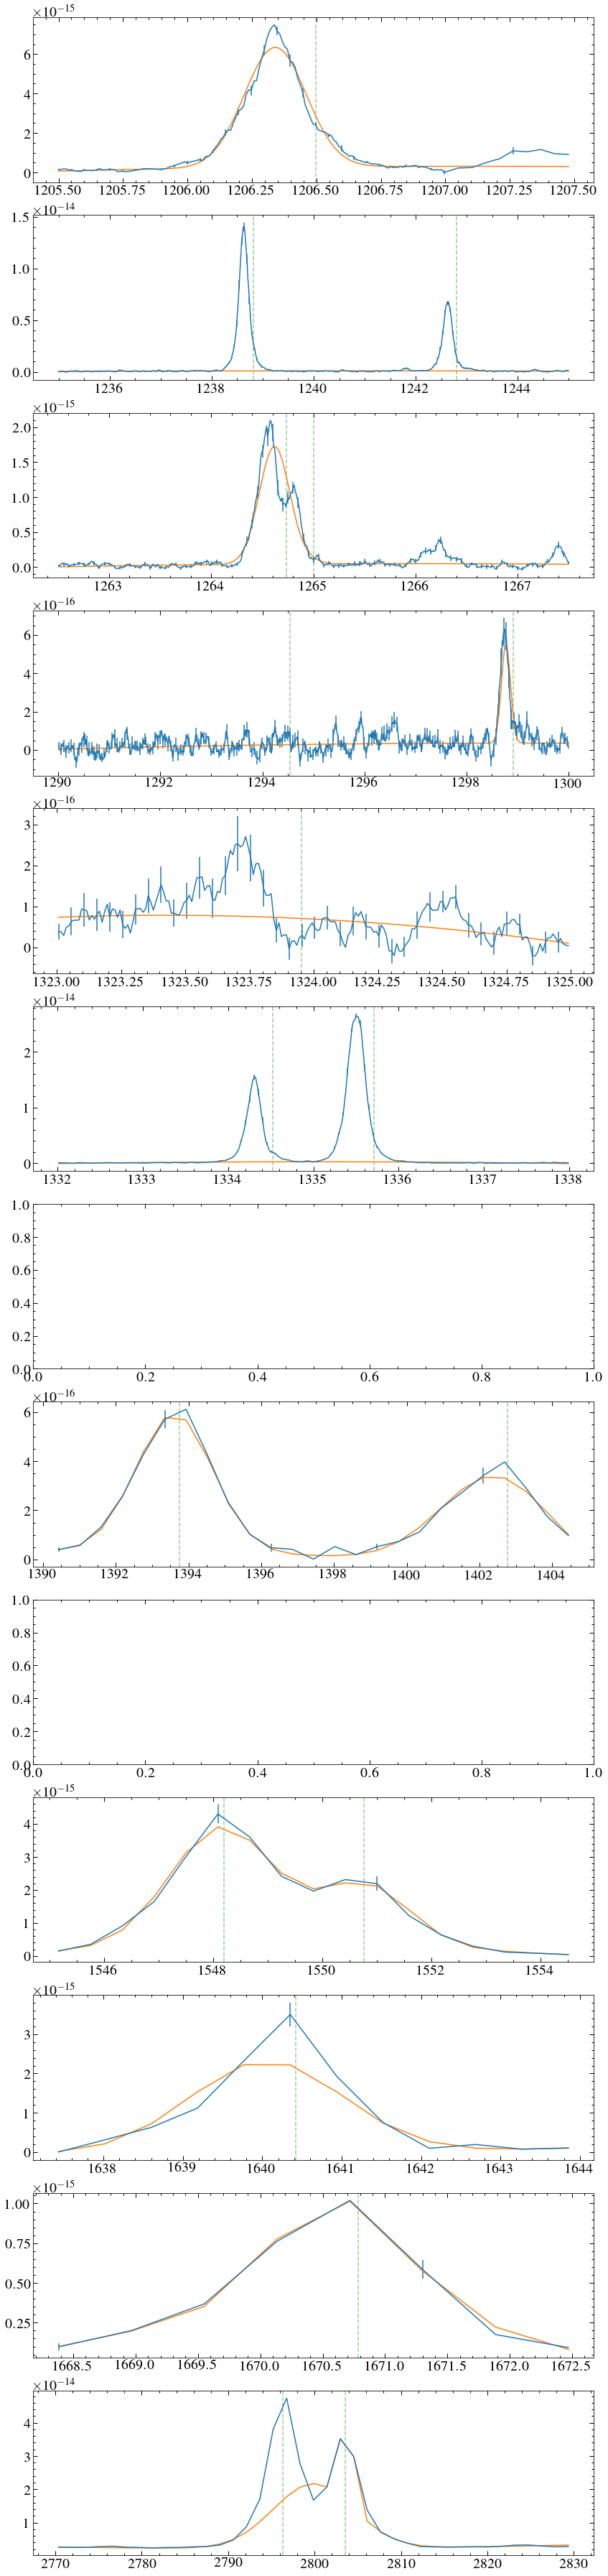

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj699_broadband_v1_var-res-sed.fits
44.028178948158796 km / s 19.22589671351063 km / s
5.64410157508718 km / s 5.8134107237283725 km / s
-88.05456062250985 km / s 25.14497536637803 km / s
-162.20683853844903 km / s 46.949362490299414 km / s
-102.42448793622592 km / s 26.524393536723238 km / s
-143.3912368371012 km / s 75.35884684164472 km / s
-80.48373222985043 km / s 16.136132824388703 km / s
-92.78549018400986 km / s 15.477763907241382 km / s
6.9546332201781285 km / s 10.353075714936857 km / s
-2.3159014776457982 km / s 13.810635035532737 km / s


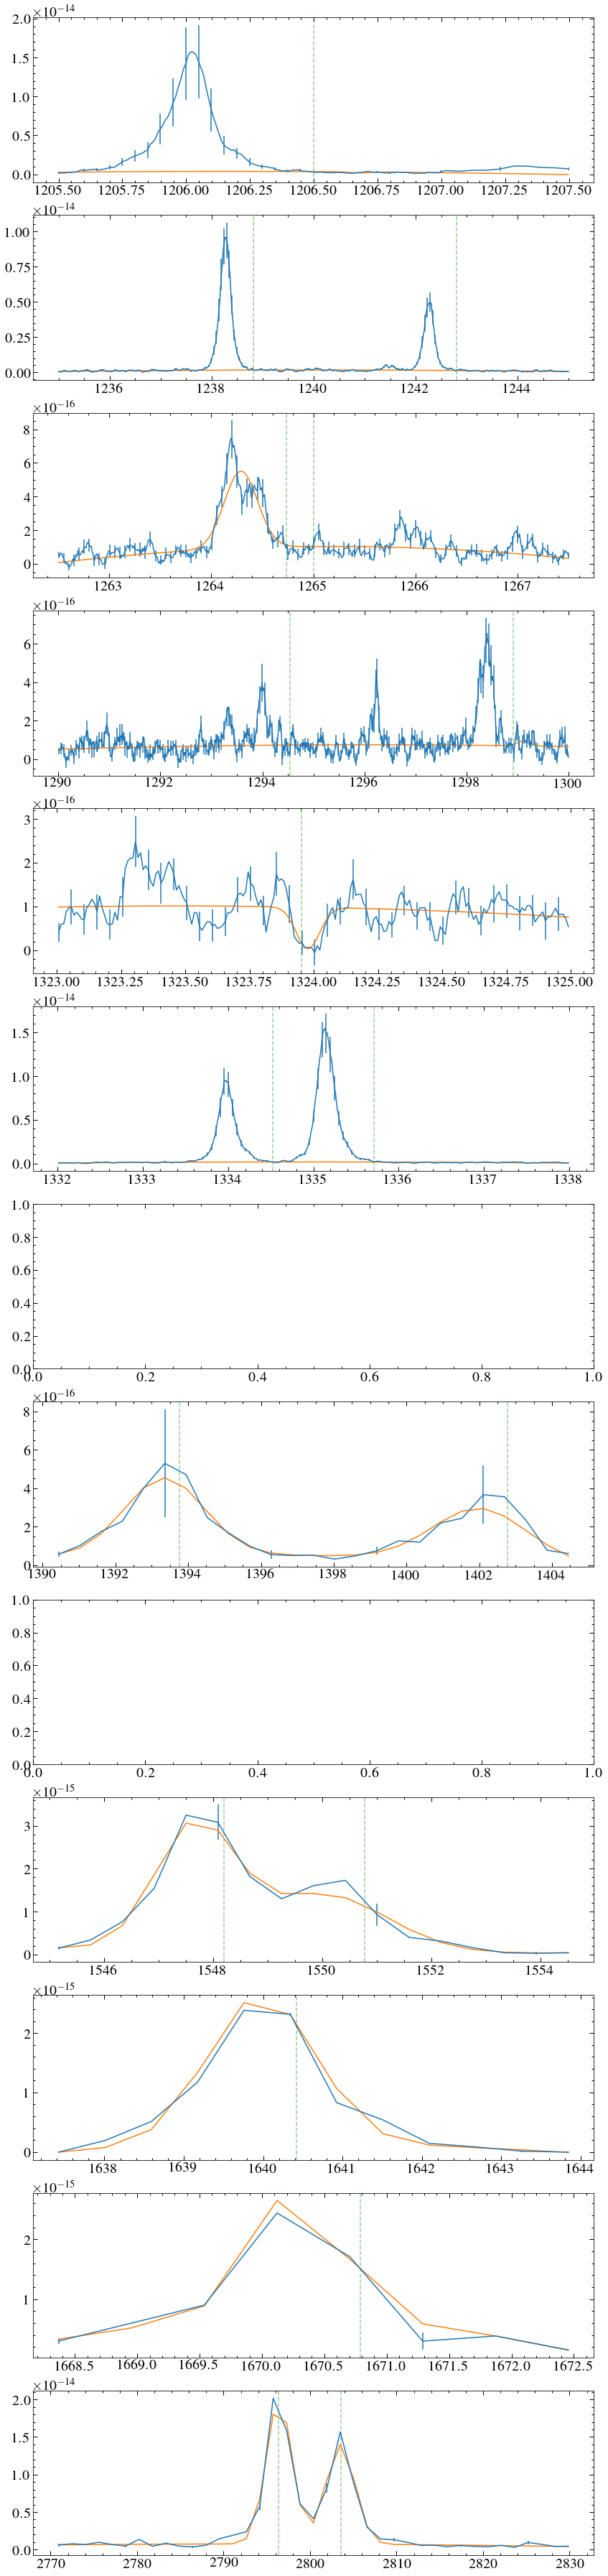

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj729_broadband_v1_var-res-sed.fits
16.47734949107145 km / s 2.360503793879025 km / s
-8.59867026942288 km / s 11.452940272887243 km / s
4.705465592307035 km / s 7.370961416765288 km / s
17.35504130306228 km / s 13.371135114522527 km / s
24.014158443806288 km / s 47.19946321555137 km / s
-370.2732930373443 km / s 35.17509968236726 km / s
-142.0882676605191 km / s 11.703923338969133 km / s
-3.9765240824603554 km / s 18.813776984688943 km / s
15.332763174735893 km / s 8.293780451498375 km / s
12.82203073079294 km / s 0.7989746058499367 km / s
14.197951617930599 km / s 2.059238222436811 km / s
11.140551726339076 km / s 8.42021883051212 km / s
13.47129281329408 km / s 1.3818015712079417 km / s
-1.7090199518906022 km / s 6.911532009226812 km / s
11.997666403116792 km / s 3.437256645264312 km / s


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


131.74546857139833 km / s 24.691376182717946 km / s
85.35820104805019 km / s 34.1497690209373 km / s


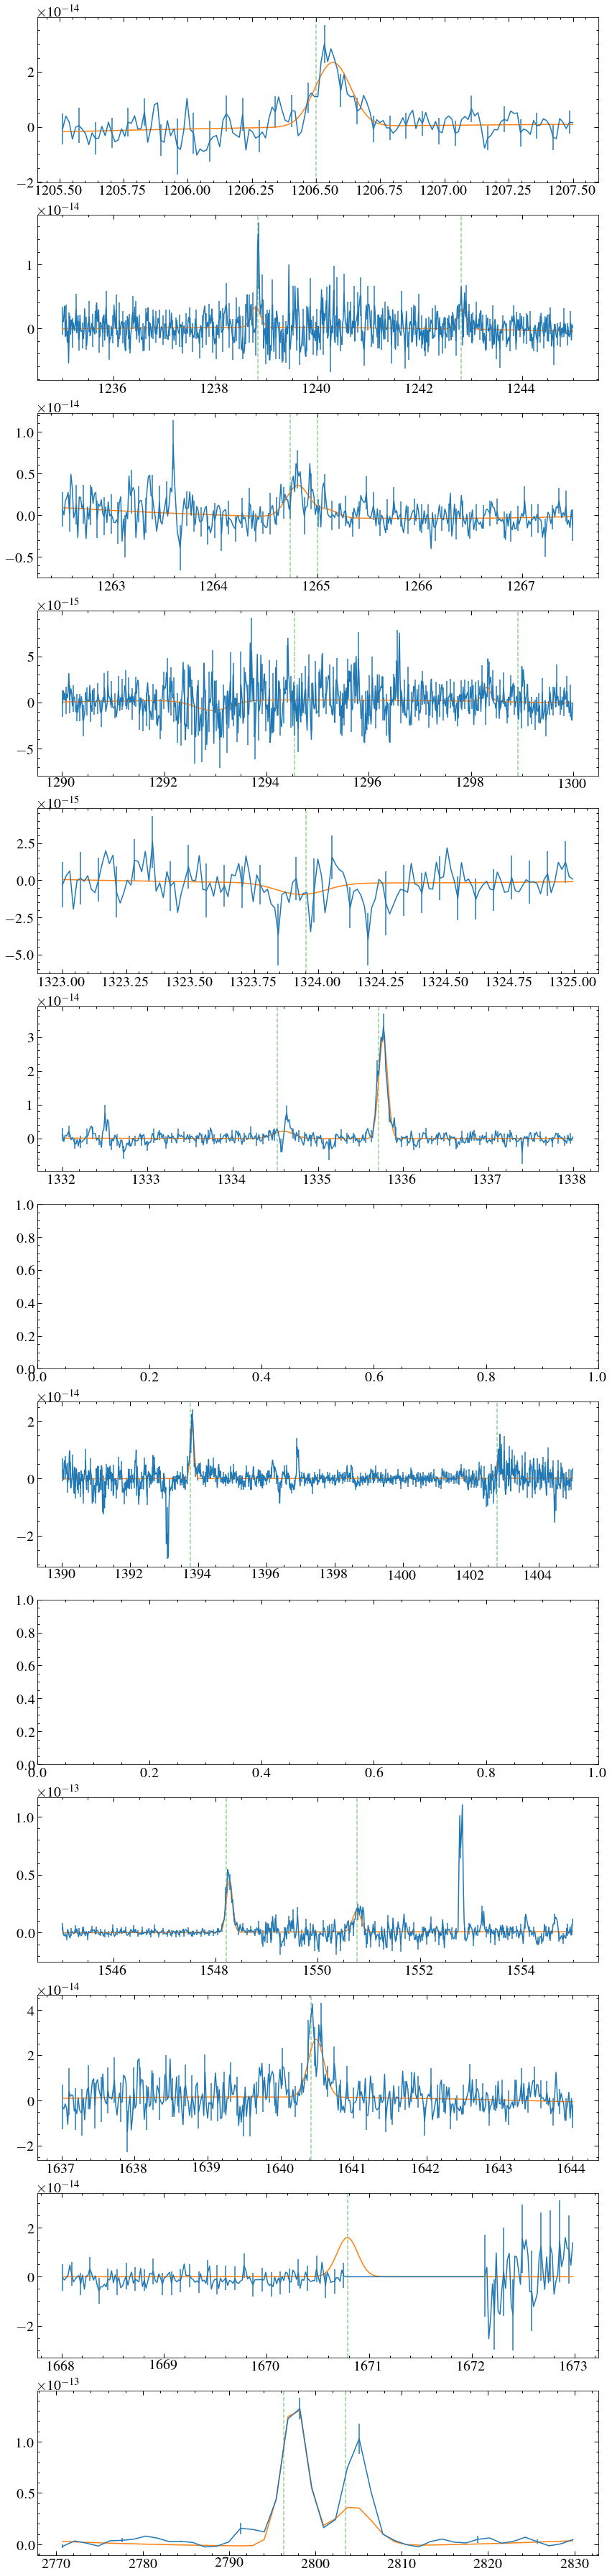

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj849_broadband_v1_var-res-sed.fits
-18.582375882152526 km / s 0.6075693598862841 km / s
-24.759170147532313 km / s 0.3385994773259977 km / s
-22.132820346590695 km / s 0.5131206898746061 km / s
-16.632464947756077 km / s 1.6500051905460138 km / s
-9.596811376338676 km / s 2.964568413422779 km / s
-8.371005036126485 km / s 4.174820462205522 km / s
-7.512125380133071 km / s 1.814854662881595 km / s
-9.192168554398533 km / s 5.60092725688386 km / s
-19.72208520235605 km / s 1.1436514382309806 km / s
-18.28358260131563 km / s 0.3032352159591092 km / s
-14.129355745369288 km / s 0.7059729104241192 km / s
-12.928626392286747 km / s 1.0897984320758098 km / s
-30.20376173819068 km / s 0.4840405453011556 km / s
-27.18096522977196 km / s 0.8315894300904638 km / s
-22.98141524252714 km / s 0.7094927654873882 km / s
-15.062427380832055 km / s 1.023505180611755 km / s
102.9928969441511 km / s 14.23980027457391 

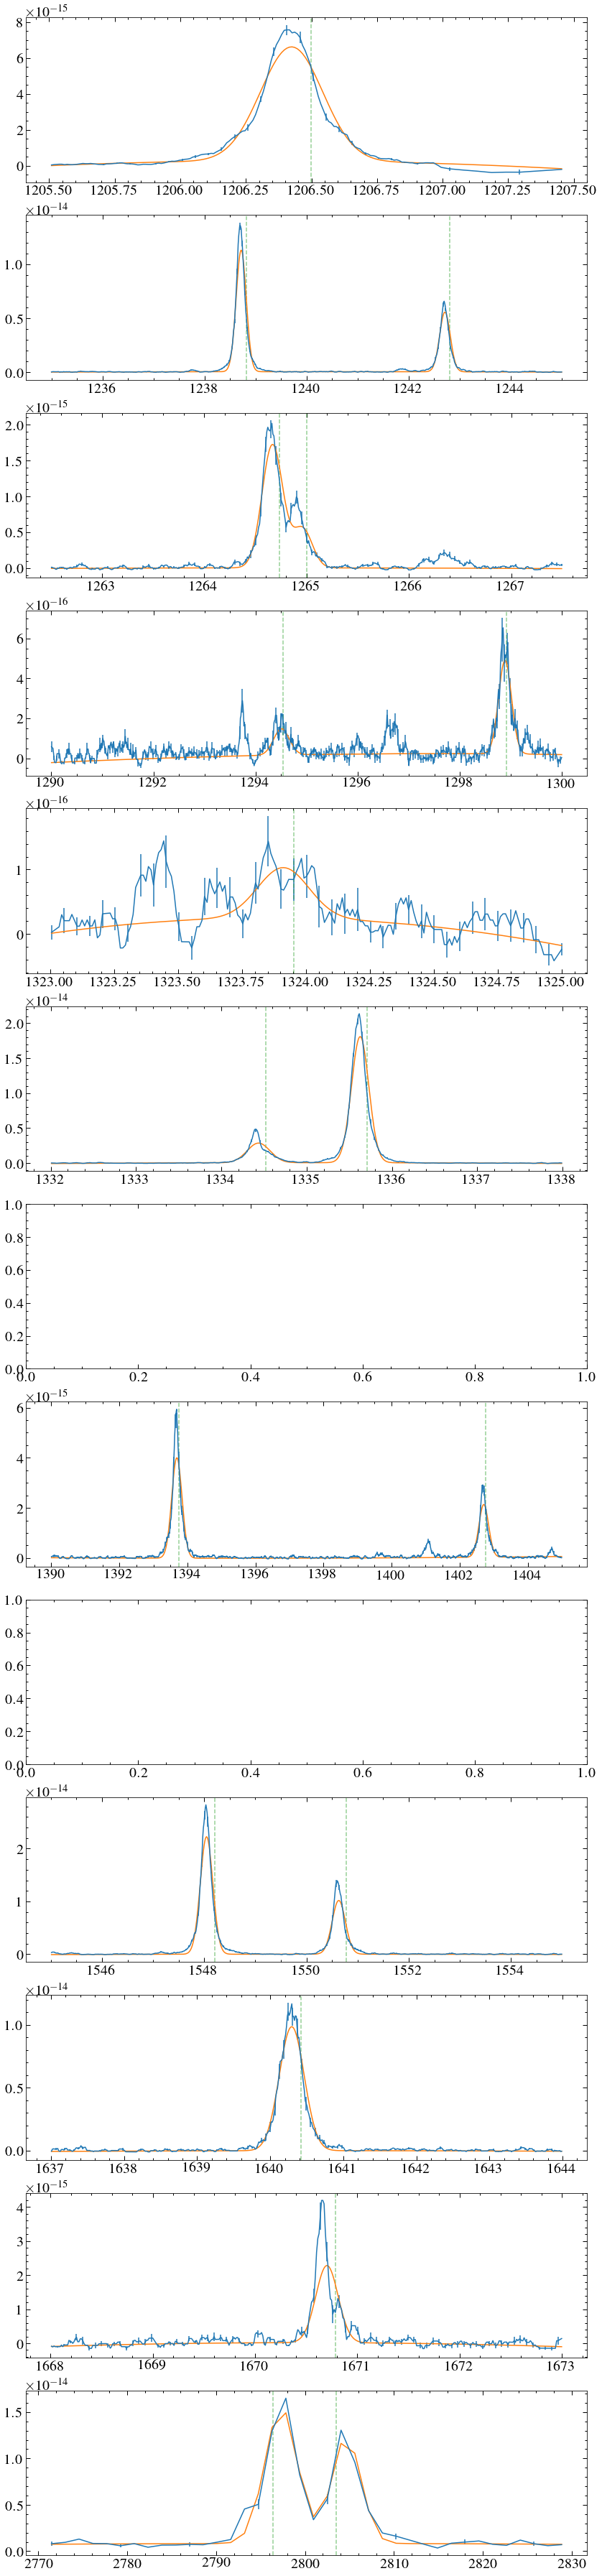

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_l-980-5_broadband_v1_var-res-sed.fits
10.419640718640975 km / s 6.061780121231182 km / s
-1.7268541324672377 km / s 1.177837374367253 km / s
0.4237657244686324 km / s 1.6048803040163568 km / s
5.311649027142031 km / s 8.589172687800144 km / s
34.62445856730345 km / s 3.9943493069063134 km / s
-32.39465834747364 km / s 10.677920530208187 km / s
22.79069807922359 km / s 1.036214685198754 km / s
16.223795542923956 km / s 0.8561412159843664 km / s
19.646924564025234 km / s 1.393268576560489 km / s
45.2810235552208 km / s 2.101387614954671 km / s
17.53185262520144 km / s 0.9824772571968694 km / s
11.786631010250352 km / s 1.5934728489197747 km / s
7.026315002793631 km / s 1.6237512774303502 km / s
15.660456706001073 km / s 1.943864529640142 km / s


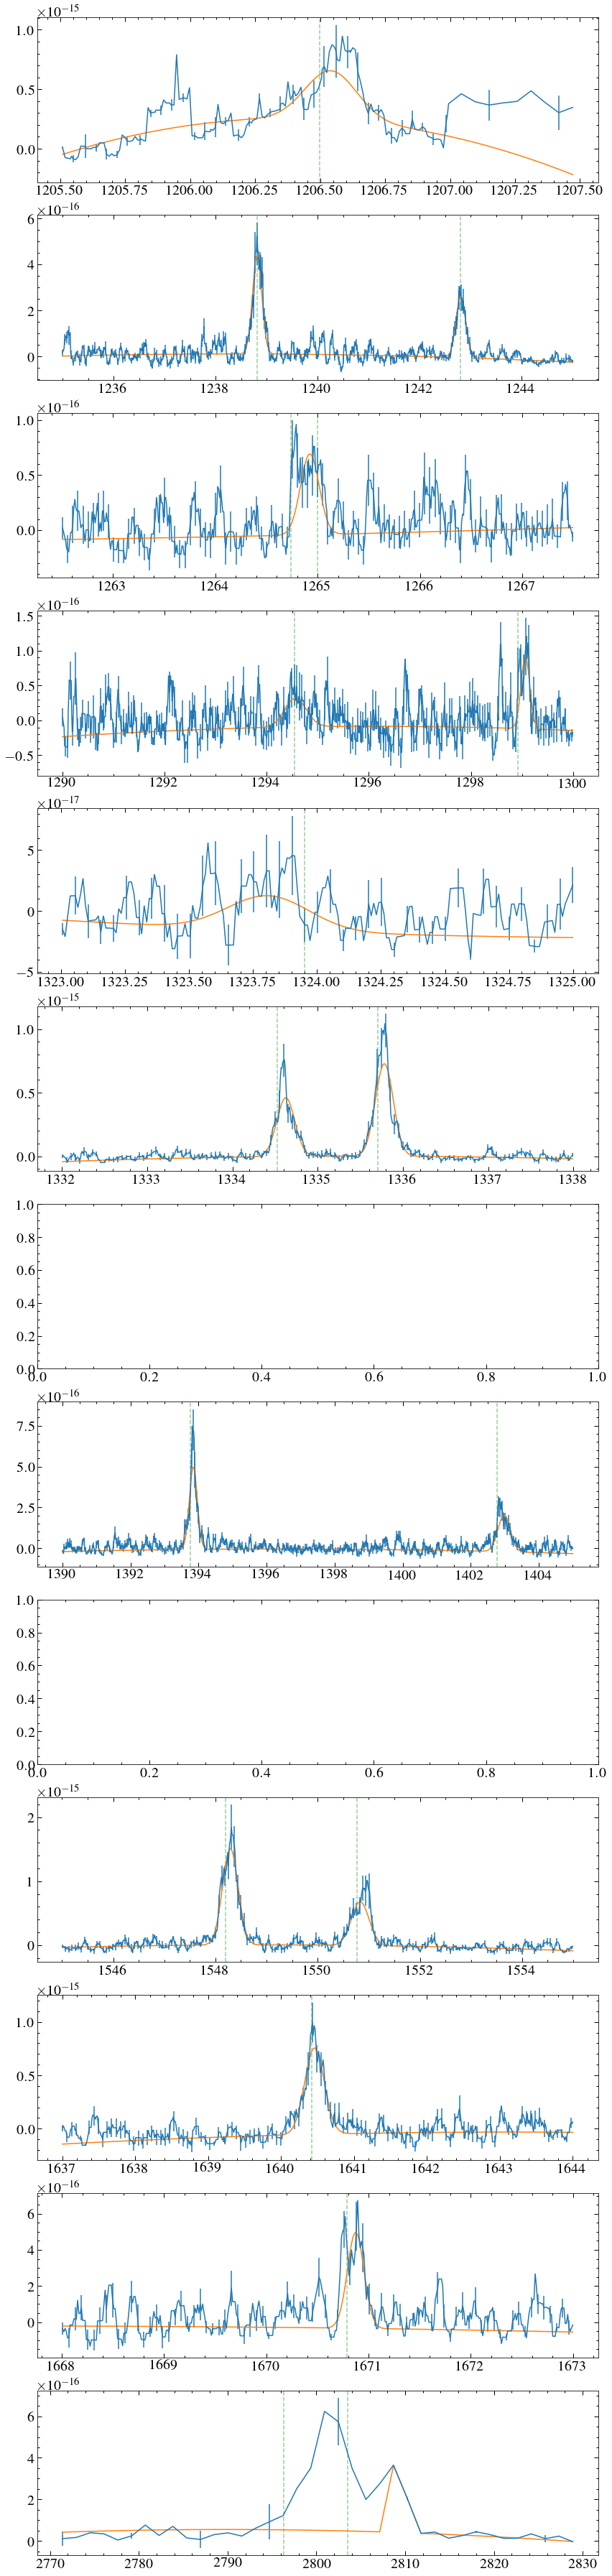

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_lhs-2686_broadband_v1_var-res-sed.fits
5.071188785744568 km / s 0.5874933613647579 km / s
7.540706730434941 km / s 0.4402772343705932 km / s
9.035750526735281 km / s 0.5331310123178632 km / s
-0.5395119653084335 km / s 6.905503526650387 km / s
-3.626855883158355 km / s 8.928075826650076 km / s
1.7469191348699604 km / s 1.789151046623356 km / s
10.32592619607588 km / s 1.3557032660907513 km / s
4.1577603558245535 km / s 1.677409942306407 km / s
12.177699034225862 km / s 0.7688977191531627 km / s
3.257634661425503 km / s 0.5246625776958567 km / s
-2.0284868345394624 km / s 31.96009968187201 km / s
-81.61670075075965 km / s 94.15739561046945 km / s
-9.472867870786208 km / s 49.19065163835626 km / s
-8.414111618659337 km / s 65.83129365929936 km / s
-7.212873365873499 km / s 8.17627880387024 km / s
-69.5109573644351 km / s 8.648572293782046 km / s


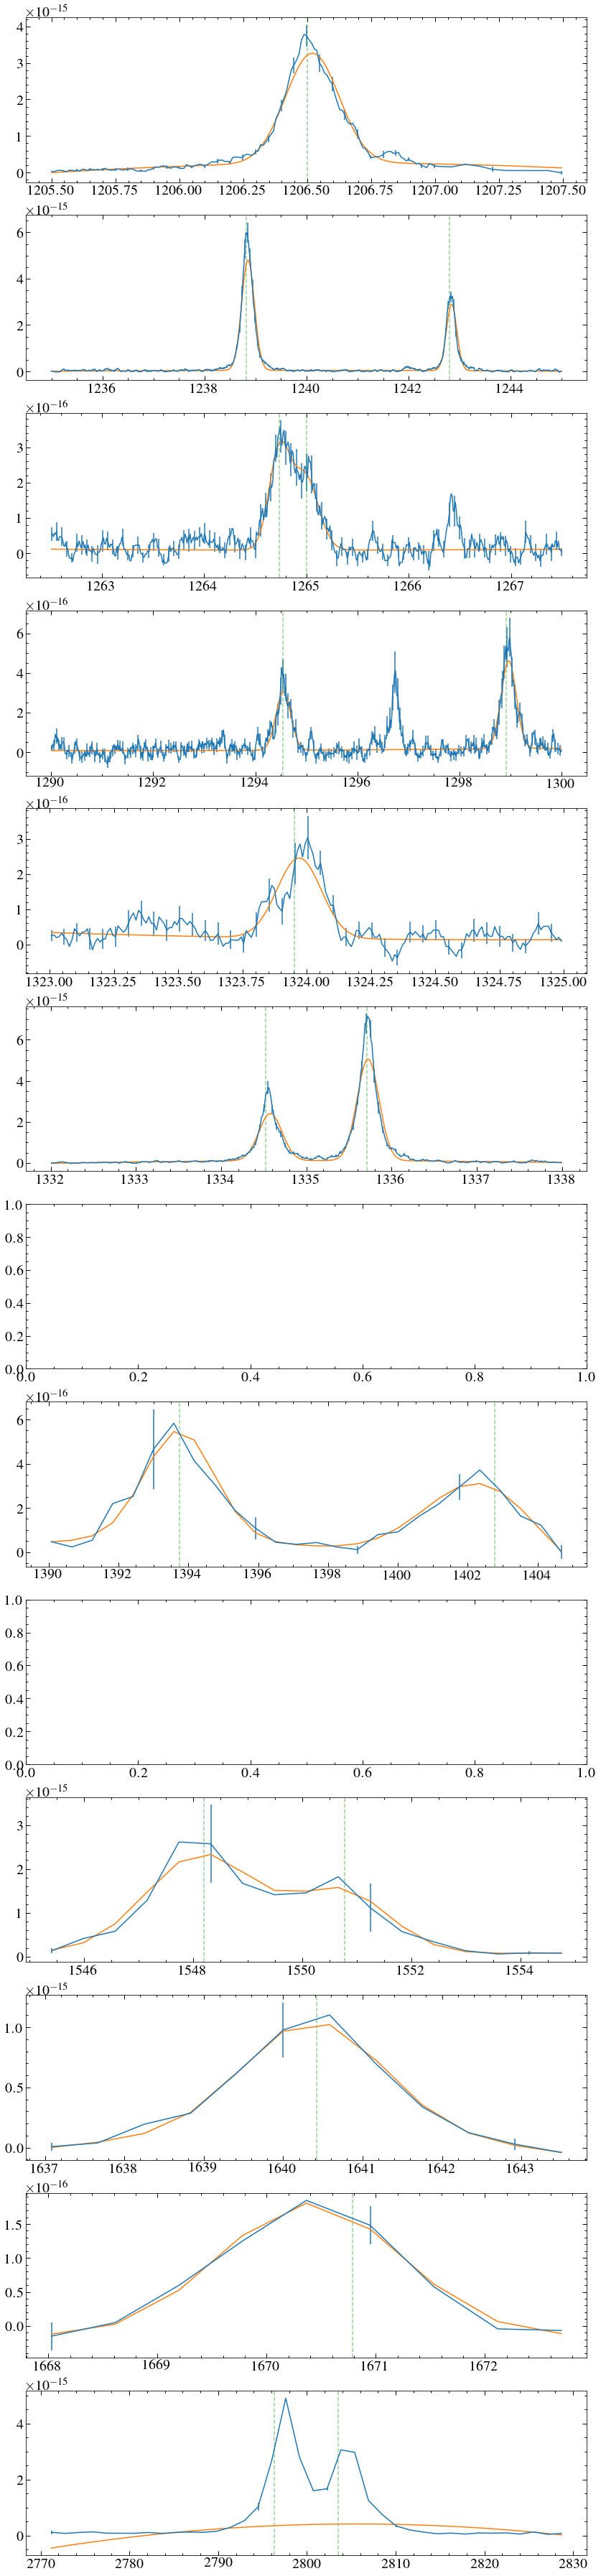

/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_trappist-1_broadband_v1_var-res-sed.fits
46.03347007008374 km / s 8.893410313721873 km / s
-64.61545034105411 km / s 4.392865684136979 km / s
-58.79898771089575 km / s 8.8677989349422 km / s
6.911749674738526 km / s 7.327892328728948 km / s
0.7786151278941941 km / s 11.493412307591981 km / s


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


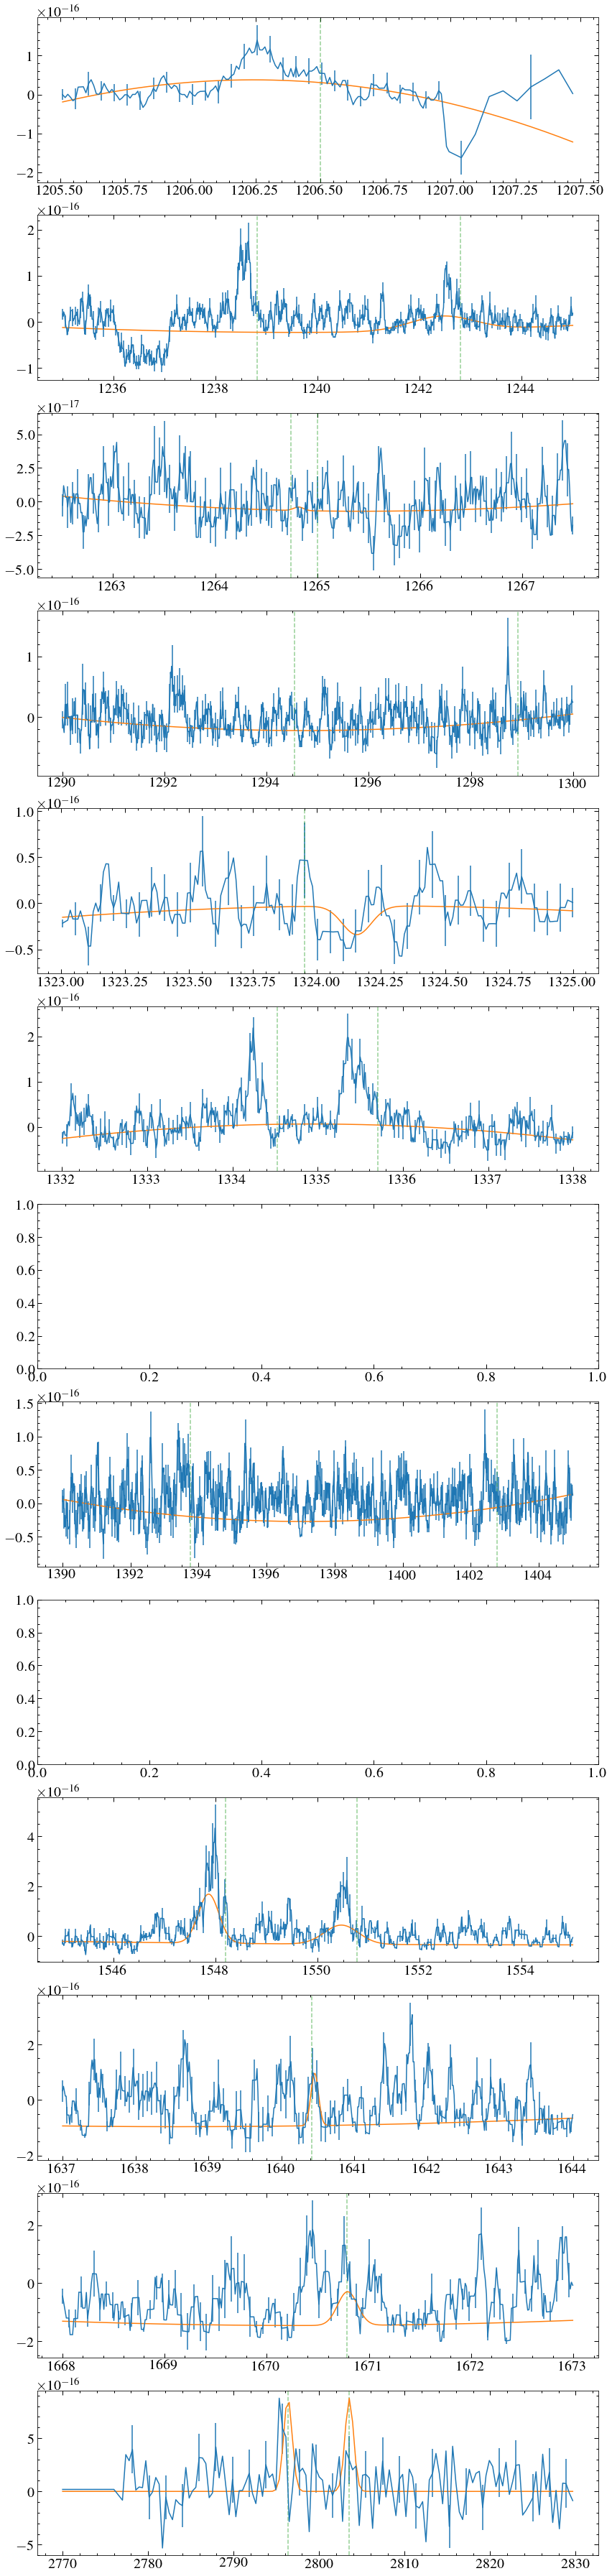

In [50]:
lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


chunks = [[1205.5, 1207.5], [1235, 1245], [1262.5, 1267.5], [1290, 1300], [1323, 1325], [1332, 1338], [1350, 1352.5], [1390, 1405], 
          [1520, 1540], 
          [1545, 1555], [1637, 1644], [1668, 1673], [2770, 2830]]

for spec in specs:
    print(spec)
    plt.figure(figsize = (14, 5*len(chunks)))
    data = fits.getdata(spec, 1)
    
    #50 AA chunks?
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']



    dv_guess = 0*u.km/u.s

    smooth =7 

    dvs = []
    dv_es = []

    for i, chunk in enumerate(chunks):
        plt.subplot(len(chunks), 1 , i+1)
        start, end = chunk[0], chunk[1]
        mask = (w >= start) & (w <= end)

        lmask = (lines >= start) & (lines <= end)
        if len(lines[lmask]) > 0 and len(w[mask]) >0:
        #         plt.plot(w[mask], f[mask])
            fi, ei = f[mask], e[mask]

        #         mod = models.Const1D(0)
            mod = models.Polynomial1D(2)
            std_guess = 0.5
            if np.median(inst[mask]) in [1, 2, 16]:
                std_guess = 0.1
            if np.median(inst[mask]) in [1, 2]:
                fi = convolve(fi,Box1DKernel(smooth))
                ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5

            plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
        #         print(std_guess)
            for line in lines[lmask]:
                line_guess = dv_guess.to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
                mod = mod+  models.Gaussian1D(amplitude=np.max(fi), mean = line_guess, stddev=std_guess)
#                 mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)#, bounds=dict(amplitude_L=[0, 1]))
                plt.axvline(line, ls='--', c='C2', alpha =0.5)
        #             plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
            gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=10000)
    #         print(gg_fit)
            if type(fitter.fit_info['param_cov']) == np.ndarray:
            #     print('hooray!')
                fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
                mean_es = fit_e[3:][1::3]

        #         print(gg_fit)
                for i in range(len(lines[lmask])):
#                     mean = gg_fit[i+1].x_0
                    mean = gg_fit[i+1].mean
                    mean_e = mean_es[i]
    #                 line_e = 
            #             obs_line = gg_fit[i+1].mean*u.AA

                    dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                    eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                    edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[lmask][i]*u.AA))
                    dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
                    print(dv, dve)
                    dvs.append(dv)
                    dv_es.append(dve)



            plt.plot(w[mask], gg_fit(w[mask]))
    plt.show()
    #     start += step


(1200.0, 1220.0)

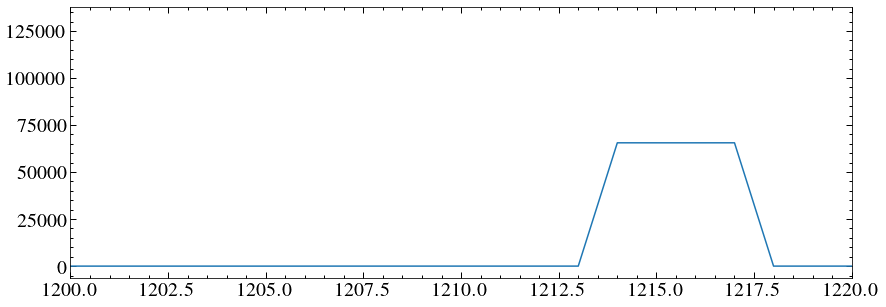

In [44]:
plt.plot(data['WAVELENGTH'], data['INSTRUMENT'])
plt.xlim(1200, 1220)